In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_orders = pd.read_csv('./datasets/data_orders.csv')
data_offers = pd.read_csv('./datasets/data_offers.csv')

# Merge data_orders and data_offers on 'order_gk'
# merged_data = pd.merge(data_orders, data_offers, on='order_gk', how='inner')

# Convert 'order_datetime' column to datetime type
# merged_data['order_datetime'] = pd.to_datetime(merged_data['order_datetime'])

In [2]:
merged_data = data_orders
data_orders

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN
...,...,...,...,...,...,...,...,...
10711,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0
10712,13:13:55,-0.975372,51.457846,NaN,3000599186962,4,0,4.0
10713,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0
10714,13:16:28,-0.975372,51.457846,NaN,3000599187024,4,0,6.0


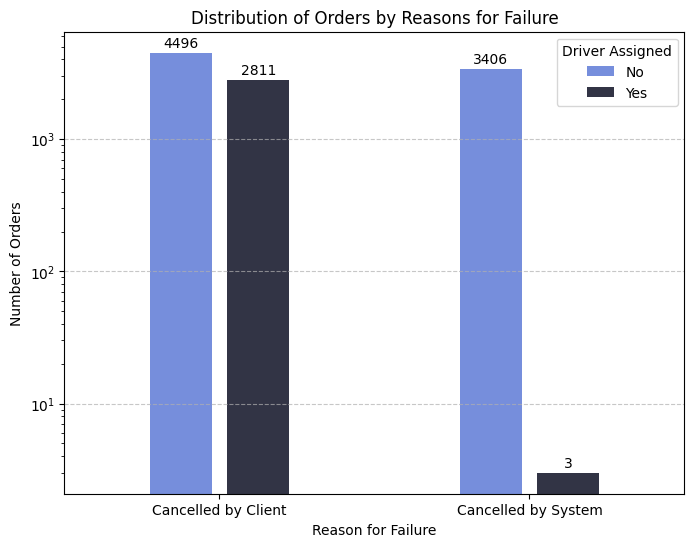

In [3]:
custom_palette = ["#6585ed","#2f3148"]

plt.figure(figsize=(8, 6))

counts = merged_data.groupby(['order_status_key', 'is_driver_assigned_key']).size().reset_index(name='count')

sns.barplot(x='order_status_key', y='count', hue='is_driver_assigned_key', data=counts, palette=custom_palette, errorbar=None, width=0.5, gap=0.2)
plt.title('Distribution of Orders by Reasons for Failure')
plt.xlabel('Reason for Failure')
plt.ylabel('Number of Orders')
plt.legend(title='Driver Assigned', labels=['No', 'Yes'])

for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 7), textcoords='offset points')

plt.yscale('log')
plt.xticks(ticks=[0, 1], labels=['Cancelled by Client', 'Cancelled by System'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('1.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
merged_data['order_datetime'] = pd.to_datetime(merged_data['order_datetime'])

def get_failure_category(row):
    if row['is_driver_assigned_key'] == 0 and row['order_status_key'] == 4:
        return 'Cancelled by Client & Driver not Assigned'
    elif row['is_driver_assigned_key'] == 0 and row['order_status_key'] == 9:
        return 'Cancelled by System & Driver not Assigned'
    elif row['is_driver_assigned_key'] == 1 and row['order_status_key'] == 4:
        return 'Cancelled by Client & Driver Assigned'
    elif row['is_driver_assigned_key'] == 1 and row['order_status_key'] == 9:
        return 'Cancelled by System & Driver Assigned'
    else:
        return 'Other'

merged_data['failure category'] = merged_data.apply(get_failure_category, axis=1)
merged_data['order_hour'] = merged_data['order_datetime'].dt.hour

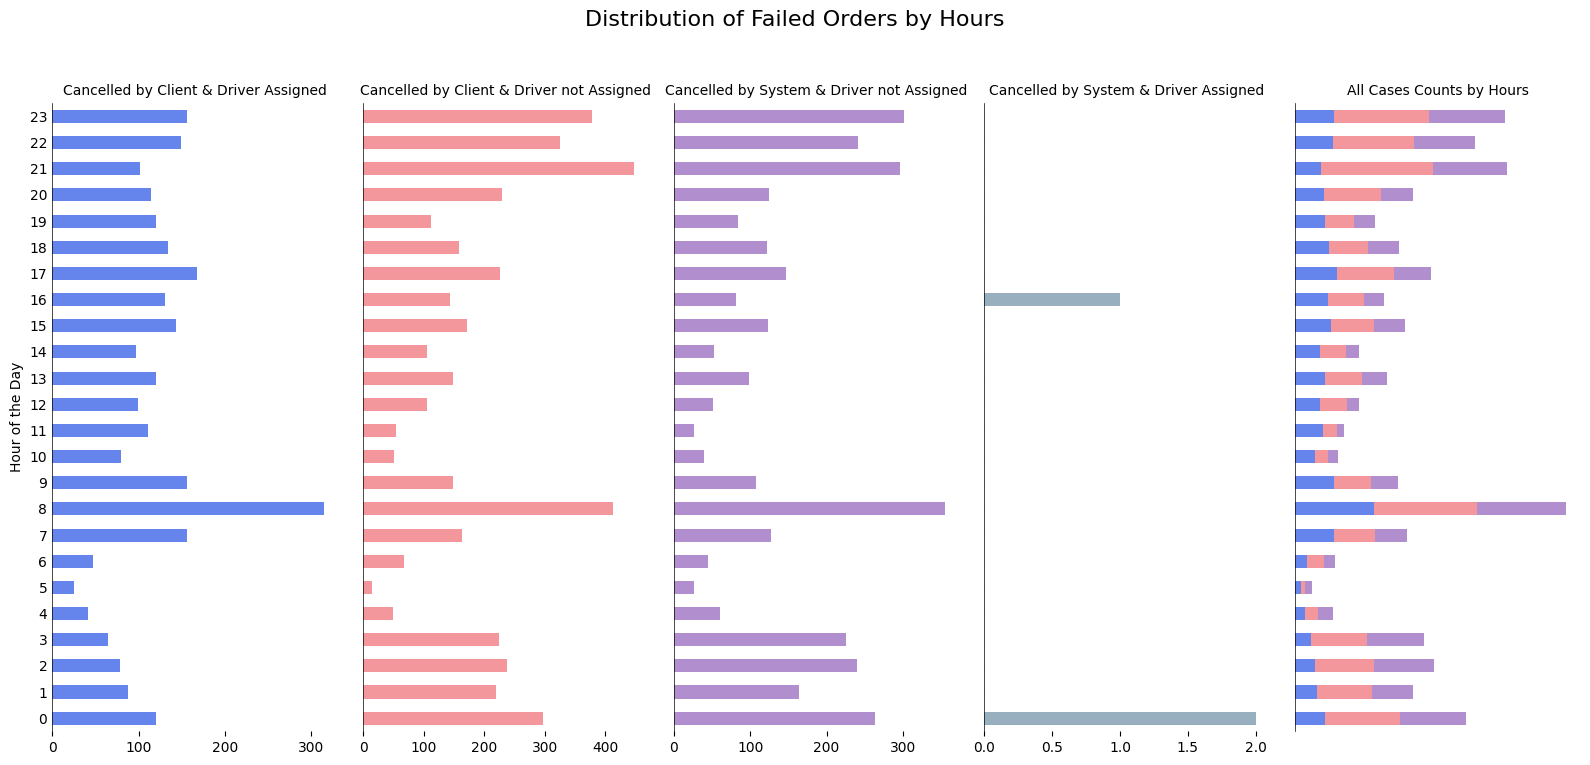

In [5]:
failure_categories = merged_data['failure category'].unique()
palette_color = ["#6585ed","#f4979c","#B18FCF","#98afc0"]

fig, axes = plt.subplots(1, len(failure_categories)+1, figsize=(16, 8), sharey=True)
for i, category in enumerate(failure_categories):
    category_data = merged_data[merged_data['failure category'] == category]
    hourly_failure_counts = category_data.groupby('order_hour').size()
    axes[i].barh(hourly_failure_counts.index, hourly_failure_counts.values, color=palette_color[i], height=0.5)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].spines['left'].set_linewidth(0.5)
    axes[i].tick_params(axis='y', which='both', length=0.1)
#     axes[i].set_xticks([])
    axes[i].set_title(category, fontsize=10)
    
axes[0].set_ylabel('Hour of the Day')
    
hourly_failure_counts = merged_data[merged_data['order_status_key'].isin([4, 9])].groupby(['order_hour', 'failure category']).size().unstack(fill_value=0)
hourly_failure_counts.plot(kind='barh', stacked=True, ax=axes[4], color=["#6585ed","#f4979c","#98afc0","#B18FCF"], legend=None)

axes[4].spines['top'].set_visible(False)
axes[4].spines['right'].set_visible(False)
axes[4].spines['bottom'].set_visible(False)
axes[4].spines['left'].set_linewidth(0.5)
axes[4].tick_params(axis='y', which='both', length=0.1)
axes[4].set_xticks([])
axes[4].set_title("All Cases Counts by Hours",fontsize=10)

plt.suptitle('Distribution of Failed Orders by Hours', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('2.png', dpi=300, bbox_inches='tight')
plt.show()

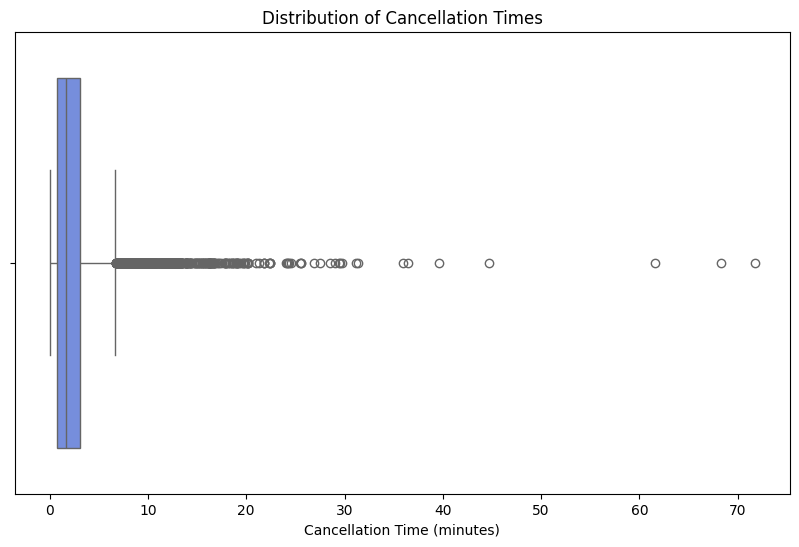

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,failure category,order_hour,cancellations_time_minutes
20,2024-04-24 13:21:15,-0.978916,51.456173,60.0,3000582916858,4,1,475.0,Cancelled by Client & Driver Assigned,13,7.916667
28,2024-04-24 22:41:17,-0.963063,51.449616,178.0,3000632496461,4,1,527.0,Cancelled by Client & Driver Assigned,22,8.783333
51,2024-04-24 14:40:45,-0.982604,51.471714,237.0,3000632296105,4,1,418.0,Cancelled by Client & Driver Assigned,14,6.966667
56,2024-04-24 18:04:34,-0.972893,51.456873,238.0,3000632372217,4,1,593.0,Cancelled by Client & Driver Assigned,18,9.883333
72,2024-04-24 23:58:55,-0.957070,51.442723,658.0,3000632521657,4,1,836.0,Cancelled by Client & Driver Assigned,23,13.933333
...,...,...,...,...,...,...,...,...,...,...,...
10655,2024-04-24 18:11:01,-0.975709,51.433680,179.0,3000554972361,4,1,461.0,Cancelled by Client & Driver Assigned,18,7.683333
10670,2024-04-24 17:23:50,-0.947560,51.444010,659.0,3000554947422,4,1,407.0,Cancelled by Client & Driver Assigned,17,6.783333
10683,2024-04-24 07:57:43,-0.977152,51.463967,60.0,3000554721424,4,1,481.0,Cancelled by Client & Driver Assigned,7,8.016667
10693,2024-04-24 16:20:30,-0.971275,51.468651,298.0,3000554922773,4,1,501.0,Cancelled by Client & Driver Assigned,16,8.350000


In [6]:
merged_data['order_datetime'] = pd.to_datetime(merged_data['order_datetime'])
merged_data['cancellations_time_minutes'] = merged_data['cancellations_time_in_seconds'] / 60

plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_data['cancellations_time_minutes'], color="#6585ed")
plt.title('Distribution of Cancellation Times')
plt.xlabel('Cancellation Time (minutes)')
plt.savefig('3-1.png', dpi=300, bbox_inches='tight')
plt.show()

Q1 = merged_data['cancellations_time_minutes'].quantile(0.25)
Q3 = merged_data['cancellations_time_minutes'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = 1.5 * IQR
outliers = merged_data[(merged_data['cancellations_time_minutes'] < Q1 - outlier_threshold) | 
                       (merged_data['cancellations_time_minutes'] > Q3 + outlier_threshold)]

outliers

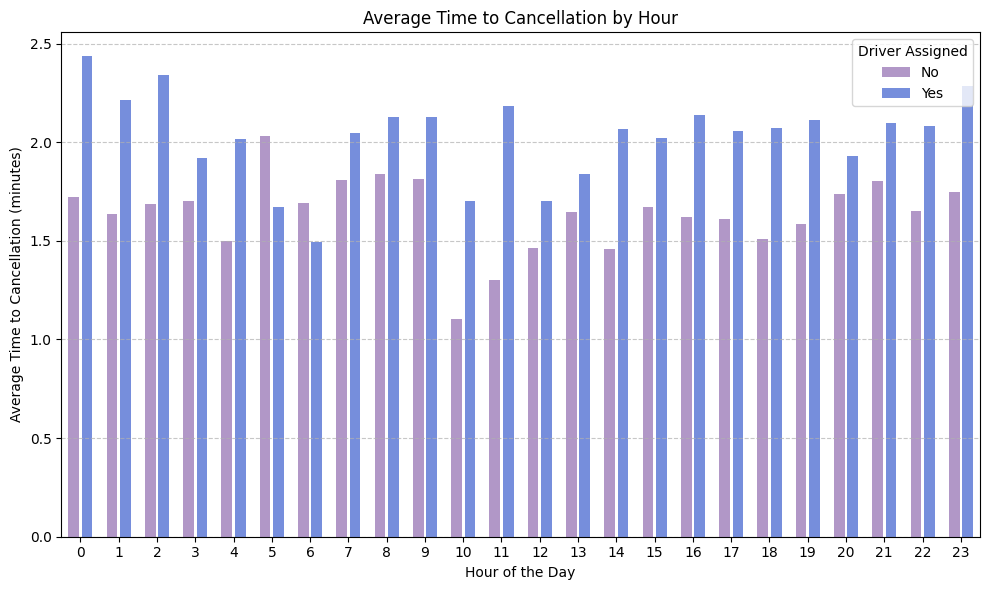

In [7]:
merged_data2 = merged_data[(merged_data['cancellations_time_minutes'] >= Q1 - outlier_threshold) & 
                          (merged_data['cancellations_time_minutes'] <= Q3 + outlier_threshold)]

# merged_data2['order_hour'] = merged_data['order_datetime'].dt.hour
colors=["#B18FCF","#6585ed"]

plt.figure(figsize=(10, 6))
sns.barplot(x='order_hour', y='cancellations_time_minutes', hue='is_driver_assigned_key', data=merged_data2, palette=colors, errorbar=None, width=0.7, gap=0.2)
plt.title('Average Time to Cancellation by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Time to Cancellation (minutes)')
plt.legend(title='Driver Assigned', labels=['No', 'Yes'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(24))
plt.tight_layout()
plt.savefig('3-2.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=merged_data2, x='order_hour', hue='is_driver_assigned_key', fill=True, palette=['#B18FCF', '#6585ed'], alpha=0.5)
plt.title('Kernel Density Estimate of Cancellation Time by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Density')
plt.legend(title='Driver Assigned', labels=['No', 'Yes'])
plt.show()

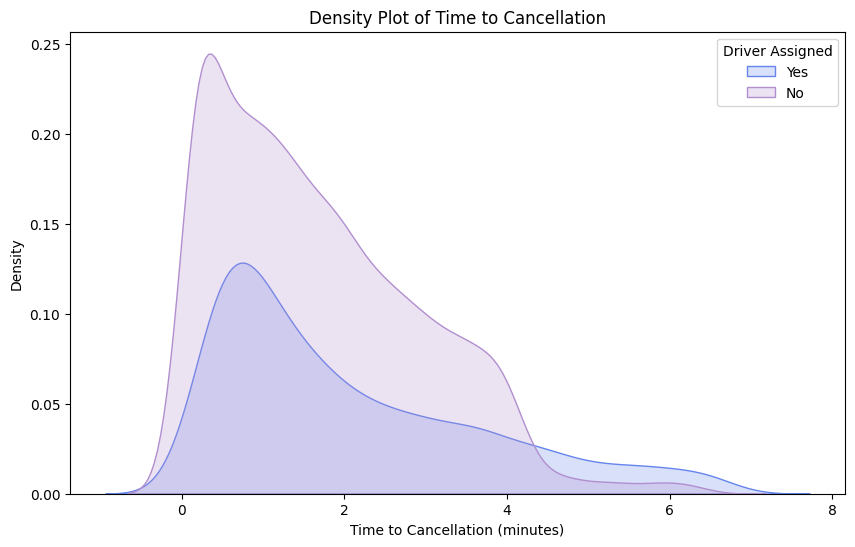

In [15]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_data2, x='cancellations_time_minutes', hue='is_driver_assigned_key', fill=True, palette=colors)
plt.title('Density Plot of Time to Cancellation')
plt.xlabel('Time to Cancellation (minutes)')
plt.legend(title='Driver Assigned', labels=['Yes', 'No'])
plt.savefig('3-3.png', dpi=300, bbox_inches='tight')
plt.show()

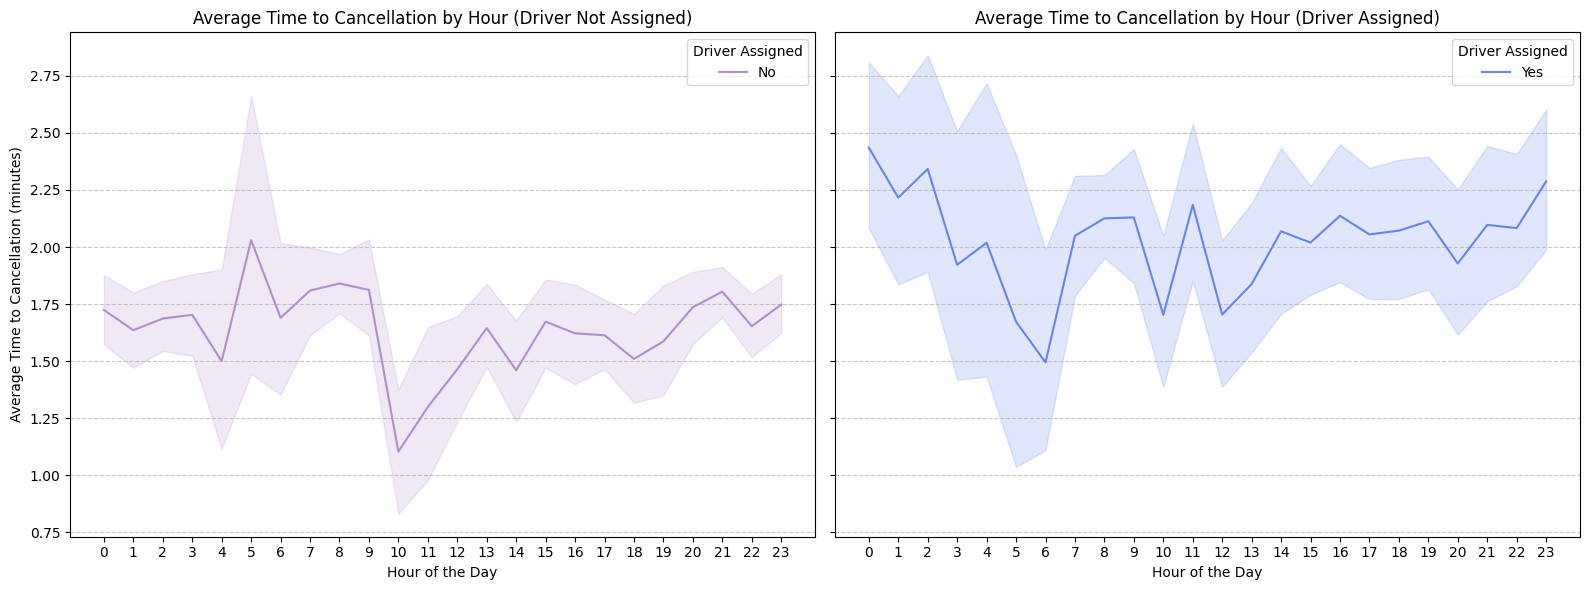

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.lineplot(ax=axes[0], x='order_hour', y='cancellations_time_minutes', data=merged_data2[merged_data2['is_driver_assigned_key'] == 0], color = colors[0])
axes[0].set_title('Average Time to Cancellation by Hour (Driver Not Assigned)')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Average Time to Cancellation (minutes)')
axes[0].legend(title='Driver Assigned', labels=['No'])
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].set_xticks(range(24))

sns.lineplot(ax=axes[1], x='order_hour', y='cancellations_time_minutes',data=merged_data2[merged_data2['is_driver_assigned_key'] == 1], color = colors[1])
axes[1].set_title('Average Time to Cancellation by Hour (Driver Assigned)')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Average Time to Cancellation (minutes)')
axes[1].legend(title='Driver Assigned', labels=['Yes'])
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].set_xticks(range(24))

plt.tight_layout()
plt.savefig('3-4.png', dpi=300, bbox_inches='tight')
plt.show()

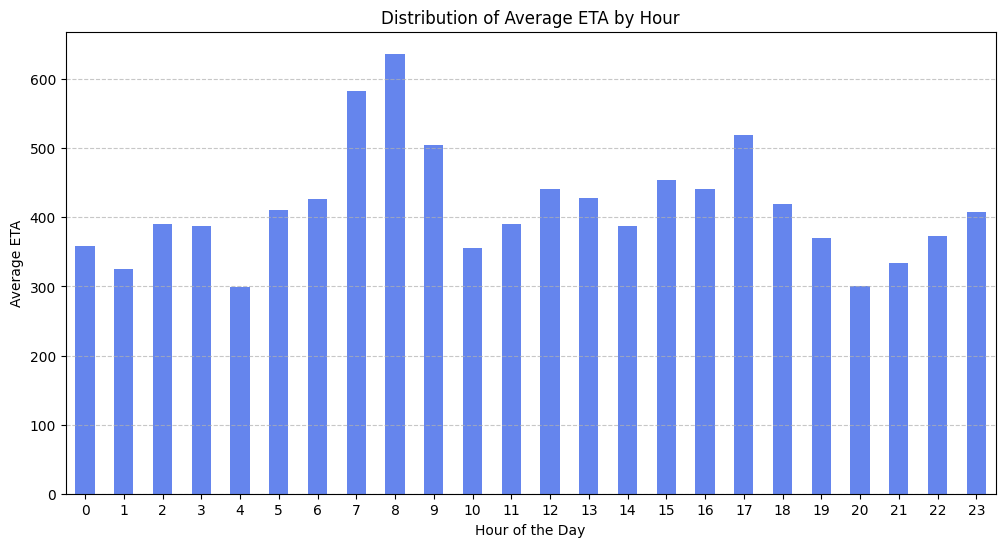

In [17]:
average_eta_by_hour = merged_data.groupby('order_hour')['m_order_eta'].mean()

plt.figure(figsize=(12, 6))
average_eta_by_hour.plot(kind='bar', color="#6585ed")
# sns.lineplot(x='order_hour', y='m_order_eta', data=merged_data2, color="#B18FCF")
plt.title('Distribution of Average ETA by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# sns.lineplot(x='order_hour', y='m_order_eta',data=merged_data2, color = 'red')
# plt.savefig('4-1.png', dpi=300, bbox_inches='tight')
plt.show()

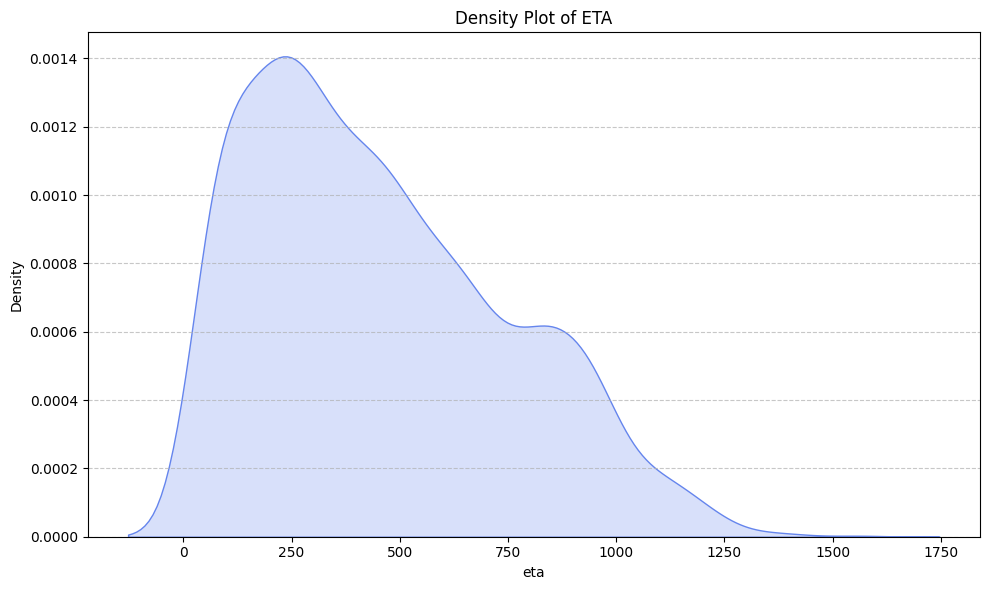

In [13]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_data2, x='m_order_eta', fill=True, color="#6585ed")
plt.title('Density Plot of ETA')
plt.xlabel('eta')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('4-2.png', dpi=300, bbox_inches='tight')
plt.show()

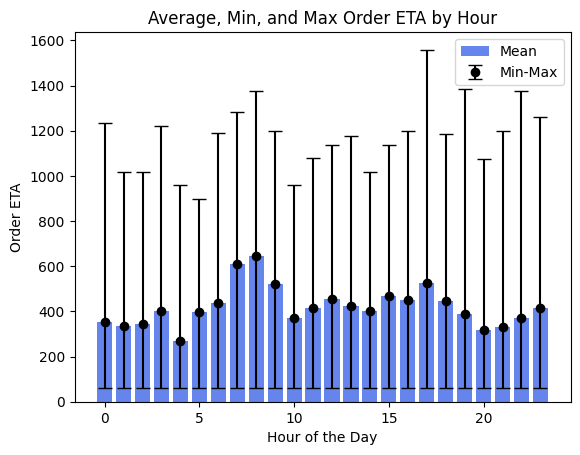

In [44]:
# hourly_stats = merged_data2.groupby('order_hour')['m_order_eta'].agg(['mean', 'min', 'max'])

# # 提取平均值、最小值和最大值
# average_eta_by_hour = hourly_stats['mean']
# min_eta_by_hour = hourly_stats['min']
# max_eta_by_hour = hourly_stats['max']

# # 绘制条形图
# plt.bar(average_eta_by_hour.index, average_eta_by_hour, color="#6585ed", label='Mean')

# # 添加误差线
# plt.errorbar(average_eta_by_hour.index, average_eta_by_hour, 
#              yerr=[average_eta_by_hour - min_eta_by_hour, max_eta_by_hour - average_eta_by_hour], 
#              fmt='o', color='black', capsize=5, label='Min-Max')

# # 添加标题和标签
# plt.title('Average, Min, and Max Order ETA by Hour')
# plt.xlabel('Hour of the Day')
# plt.ylabel('Order ETA')
# plt.legend()

# # 显示图表
# plt.show()

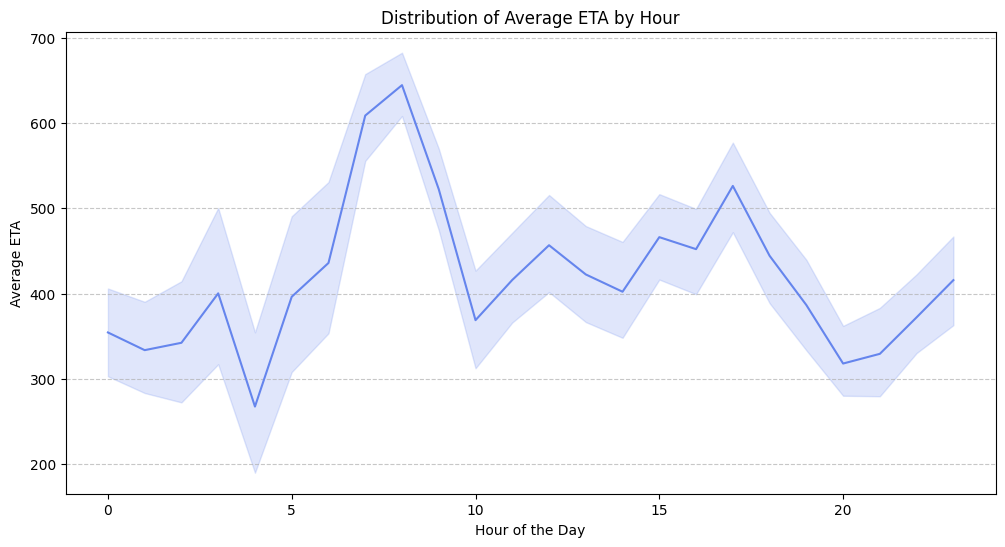

In [18]:
average_eta_by_hour = merged_data.groupby('order_hour')['m_order_eta'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x='order_hour', y='m_order_eta', data=merged_data2, color="#6585ed")
plt.title('Distribution of Average ETA by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# average_eta_by_hour.plot(kind='line', color='red', linestyle='-', linewidth=2)
plt.savefig('4-3.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
import folium
import h3
import json
import matplotlib.cm as cm
import matplotlib.colors as colors

resolution_level = 8
order_hexagons = []

for _, row in merged_data.iterrows():
    lat, lon = row['origin_latitude'], row['origin_longitude']
    hex_id = h3.geo_to_h3(lat, lon, resolution_level)
    order_hexagons.append(hex_id)

merged_data['hexagon_id'] = order_hexagons
hexagon_order_counts = merged_data['hexagon_id'].value_counts().reset_index()
hexagon_order_counts.columns = ['hexagon_id', 'order_count']
hexagon_order_counts = hexagon_order_counts.sort_values(by='order_count', ascending=False)

hexagon_order_counts['cumulative_percentage'] = hexagon_order_counts['order_count'].cumsum() / hexagon_order_counts['order_count'].sum()
selected_hexagons = hexagon_order_counts[hexagon_order_counts['cumulative_percentage'] <= 0.8]

map_center = (merged_data['origin_latitude'].mean(), merged_data['origin_longitude'].mean())
m = folium.Map(location=map_center, zoom_start=10)
folium.TileLayer(tiles='cartodbpositron', attr='CartoDB Positron').add_to(m)

light_blue = colors.to_hex((0.6, 0.8, 1.0)) 
colormap = colors.LinearSegmentedColormap.from_list('custom_blues_transparent_black', [(0, light_blue), (1, 'black')])
min_value = selected_hexagons['order_count'].min()
max_value = selected_hexagons['order_count'].max()


hexagon_group = folium.FeatureGroup(name='Hexagons')
for index, row in selected_hexagons.iterrows():
    hex_id = row['hexagon_id']
    order_count = row['order_count']
    lat, lon = h3.h3_to_geo(hex_id)
    color = colormap((order_count - min_value) / (max_value - min_value))  # 使用色谱映射值的归一化值来确定颜色
    color = colors.rgb2hex(color)  # 将RGB颜色转换为十六进制颜色
    vertices = h3.h3_to_geo_boundary(hex_id)
    folium.Polygon(
        locations=vertices,
        fill_color=color,
        fill_opacity=0.6
    ).add_to(hexagon_group)

hexagon_group.add_to(m)
folium.LayerControl().add_to(m)

m.save('hexagon_map.html')